# Лабораторная работа №2
## Линейная регрессия
Выполнила Карасева Екатерина M33351

### Данные
Выбранный набор данных из файла 4.txt:

In [287]:
filename = '4.txt'

import pandas as pd
import numpy as np


# нормализация
def min_max_normalize(arr):
    min = np.min(arr)
    max = np.max(arr)
    return arr.apply(lambda x: (x - min) / (max - min) if max - min != 0 else 1.0)


def normalise(ds):
    for i in ds.columns:
        ds[i] = min_max_normalize(ds[i])


file = open(filename, 'r')
m = file.__next__()
m = int(m)
train_n = file.__next__()
train_n = int(train_n)
train = pd.read_table(filename, sep='\s+', skiprows=2, nrows=train_n, header=None)
normalise(train)
train = train.to_numpy()
train.shape

(3415, 147)

In [288]:
from itertools import islice

lines = islice(file, train_n, None)
test_n = lines.__next__()
test_n = int(test_n)
test = pd.read_table(filename, sep='\s+', skiprows=2 + train_n + 1, nrows=test_n, header=None)
normalise(test)
test = test.to_numpy()
test.shape

(256, 147)

### Реализация метода наименьших квадратов

In [289]:
def least_squares_method(dataset: np.ndarray, tau):
    f = np.delete(dataset, -1, axis=1)
    _, num_features = f.shape
    identity = np.identity(num_features)
    f_transposed = np.transpose(f)
    y = dataset[:, -1]
    return np.linalg.inv(f_transposed @ f + tau * identity) @ f_transposed @ y

# с гребневой регуляризацией

### Реализация функций оценки

In [290]:
def smape(x, y):
    return 2 * np.sum([abs(a - b) / (abs(a) + abs(b)) for a, b in zip(x, y)]) / len(x)


def mse(x, y):
    return np.sum([(a - b) * (a - b) for a, b in zip(x, y)]) / len(x)

### График зависимости ошибки SMAPE и MSE на тестовом множестве от параметра регуляризации для метода наименьших квадратов

In [291]:
def plt_for_lsm():
    smapeList = []
    mseList = []
    for i in range(1, 100):
        w = least_squares_method(train, 1 / i)
        f = np.delete(train, -1, axis=1)
        target = train[:, -1]
        predicted = np.array([np.dot(x, w) for x in f])
        smapeList.append(smape(target, predicted))
        mseList.append(mse(target, predicted))
    return smapeList, mseList


smapeLSM, mseLSM = plt_for_lsm()

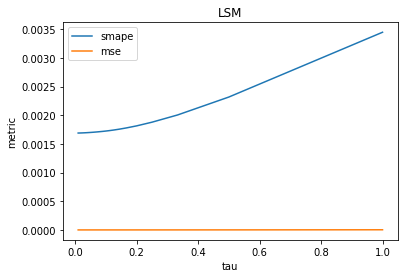

In [292]:
import matplotlib.pyplot as plt

plt.title('LSM')
plt.plot([1 / i for i in range(1, 100)], smapeLSM, label='smape')
plt.plot([1 / i for i in range(1, 100)], mseLSM, label='mse')
plt.legend()
plt.ylabel("metric")
plt.xlabel("tau")
plt.show()

### Реализация градиентного стохастического метода

In [293]:
import random


def diff_smape(x, w):
    return np.array([x[i] * (np.sign(np.dot(x, np.append(w, -1))) * (np.abs(np.dot(x[: -1], w) + np.abs(x[-1]))
                                - np.sign(np.dot(x[: -1], w)) * np.abs(np.dot(x, np.append(w, -1)))))
                     / np.square(np.abs(np.dot(x[: -1], w) + np.abs(x[-1]))) for i in range(len(x) - 1)])


def diff_mse(x, w):
    return np.array([2 * x[i] * np.dot(x, np.append(w, -1)) for i in range(len(x) - 1)])


def stochastic_gradient_descent_method(dataset: np.ndarray, tau, diff, metric):
    num_objects, cols = dataset.shape
    num_features = cols - 1

    num_iterations = 2000
    limit = 1 / (2 * num_features)
    w = np.array([random.uniform(-limit, limit) for _ in range(num_features)])
    w_list = list()
    metric_vals = list()
    metric_val = 1.
    alfa = 1 / 500

    for k in range(1, num_iterations + 1):
        w_prev = w
        object = dataset[(k - 1) % (num_objects - 1)]

        regularized_diff = diff(object, w_prev) + tau * w_prev
        mu = 1 / k
        w = w_prev - mu * regularized_diff

        target = object[-1]
        predicted = np.dot(object[:-1], w)
        metric_val = alfa * metric([target], [predicted]) + (1 - alfa) * metric_val

        metric_vals.append(metric_val)
        w_list.append(w)

    return w_list, metric_vals


# с регуляризацией LASSO

smapeW, smapeGrad = stochastic_gradient_descent_method(train, 25, diff_smape, smape)
mseW, mseGrad = stochastic_gradient_descent_method(train, 0.00001, diff_mse, mse)

### Графики зависимости экспоненциального скользящего среднего функции ошибки от итерации

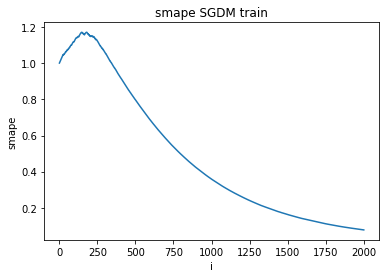

In [294]:
plt.title('smape SGDM train')
plt.plot(range(1, 2001), smapeGrad)
plt.ylabel("smape")
plt.xlabel("i")
plt.show()

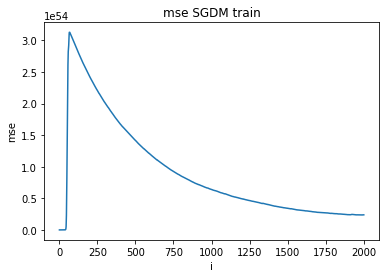

In [295]:
plt.title('mse SGDM train')
plt.plot(range(1, 2001), mseGrad)
plt.ylabel("mse")
plt.xlabel("i")
plt.show()

### Оценка трёх методов на тестовом множестве данных при помощи NRMSE и SMAPE

In [296]:
w = least_squares_method(train, 1 / 100)
f = np.delete(test, -1, axis=1)
target = test[:, -1]
predicted = np.array([np.dot(x, w) for x in f])
print('smape LSM: ' + str(smape(target, predicted)))

smape LSM: 0.4828608877792795


In [297]:
def calc_moving_avg_smape(dataset: np.ndarray, w_list):
    num_objects, cols = dataset.shape

    smape_vals = list()
    smape_val = 1.
    alfa = 1 / 500
    k = 0

    for w in w_list:
        object = dataset[k%(num_objects - 1)]
        k += 1
        target = object[-1]
        predicted = np.dot(object[:-1], w)
        smape_val = alfa * smape([target], [predicted]) + (1 - alfa) * smape_val
        smape_vals.append(smape_val)

    return smape_vals

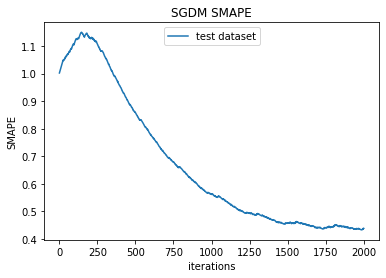

In [298]:
smape_gd_test = calc_moving_avg_smape(test, smapeW)

plt.title('SGDM SMAPE')
plt.plot(range(1, len(smape_gd_test) + 1), smape_gd_test, label='test dataset')
plt.legend(loc='upper center')
plt.xlabel('iterations')
plt.ylabel('SMAPE')
plt.show()


In [299]:
w = smapeW[-1]
f = np.delete(test, -1, axis=1)
target = test[:, -1]
predicted = np.array([np.dot(x, w) for x in f])
print('smape SGDM SMAPE: ' + str(smape(target, predicted)))

smape SGDM SMAPE: 0.45264117022092715
